# MVPA MEG Tutorial (Python): Distance measures and cross-validation

[Tutorial starting page](https://github.com/m-guggenmos/megmvpa/).

[work in progress]

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [placeholder](http://doi.org/).

**Goal of this tutorial:** comparison of Euclidean and Pearson distance measures.

## Tutorial

We start with some imports:

In [1]:
import os

import numpy as np
import scipy
from sklearn.discriminant_analysis import _cov

from cv import ShuffleBinLeaveOneOut, ShuffleBin
from dissimilarity import Euclidean2, CvEuclidean2, Pearson, CvPearson

We set a seed, in order to make analyses reproducible:

In [2]:
np.random.seed(10)

Let's load some data:

In [3]:
root = '' # This is the /path/to the directory containing the data.
          # We leave it empty here, because the data is located in the current directory.

# Load data and trial labels for the two sessions of participant 01
sessions = [
    # Session 1
    dict(
        data=np.load(os.path.join(root, 'data01_sess1.npy')),
        # data has shape n_trials x n_sensors x n_timepoints
        labels=np.load(os.path.join(root, 'labels01_sess1.npy'))
        # labels has shape 1 x n_trials (i.e., one condition label [object category] per trial)
    ),
    # Session 2
    dict(
        data=np.load(os.path.join(root, 'data01_sess2.npy')),
        labels=np.load(os.path.join(root, 'labels01_sess2.npy'))
    )
]

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [4]:
# Parameters
n_perm = 20  # number of permutations
n_pseudo = 5  # number of pseudo-trials
n_conditions = len(np.unique(sessions[0]['labels']))
n_sensors = sessions[0]['data'].shape[1]
n_time = sessions[0]['data'].shape[2]
n_sessions = len(sessions)

We define our distance measures: non-cross and cross-validated variants of the (squared) Euclidean and the Pearson distance.

In [5]:
ec = Euclidean2()
ec_cv = CvEuclidean2()
ps = Pearson()
ps_cv = CvPearson()

### Non-cross-validated distances

We start with computing non-cross-validated distances (`ec` and `ps`). For this, the analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 3 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Apply distance measure to the data

In [6]:
# pre-load mechanism, for convenience
preload_result = True # for recomputing the decoding analyses, set to False
if preload_result:
    result = np.load(os.path.join(root, 'result_distance.npy'))
else:
    result = np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan,
                     dtype={'names': ['ec', 'ps'], 'formats': 2*['f8']})
    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = ShuffleBin(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials
            Xpseudo = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(test_indices):
                Xpseudo[i, :, :] = np.mean(X[ind, :, :], axis=0)

            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_test[0, :, n_pseudo:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo = (Xpseudo.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Apply distance measure to the data
                            data = Xpseudo[cv.ind_pseudo_test[c1, c2], :, t]
                            result['ec'][s, f, c1, c2, t] = ec.predict(data, y=cv.labels_pseudo_test[c1, c2])
                            result['ps'][s, f, c1, c2, t] = ps.predict(data, y=cv.labels_pseudo_test[c1, c2])
    # average across permutations
    result_ = np.full((n_sessions, n_conditions, n_conditions, n_time), np.nan,
                      dtype={'names': ['ec', 'ps'], 'formats': 2*['f8']})
    result_['ec'] = np.nanmean(result['ec'], axis=1)
    result_['ps'] = np.nanmean(result['ps'], axis=1)
    result = result_
    np.save(os.path.join(root, 'result_distance.npy'), result_)

To take a look at the results, we use matplotlib.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

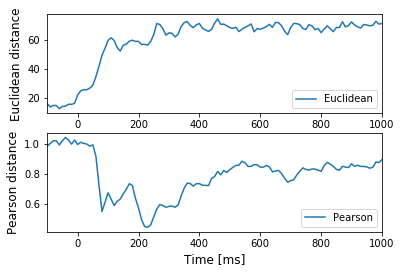

In [8]:
plt.subplot(211)
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result['ec'], axis=(0, 1, 2)), label='Euclidean')
plt.xlim((-100, 1000))
plt.ylabel('Euclidean distance', fontsize=12)
plt.legend(loc='lower right')

plt.subplot(212)
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result['ps'], axis=(0, 1, 2)), label='Pearson')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Pearson distance', fontsize=12)
plt.legend(loc='lower right')

# plt.tight_layout()

**Euclidean distance:** the Euclidean distance rises shortly after stimulus onset (at 0ms) and until it reaches a maximum. Interestingly, the distance remains at this maximum after stimulus offset (at 500ms) until the end of the epoch, although the condition-specific information content [drops to zero](https://github.com/m-guggenmos/megmvpa/blob/master/python_decoding.ipynb) towards the end of the trial. This indicates that the non-cross-validated Euclidean distance is not only influenced by condition-specific differences in activation patterns, but also by noise.

**Pearson distance:** the Pearson distance _decreases_ after stimulus onset, corresponding to an increase of the correlation between condition-specific activation patterns (note that the Pearson distance is defined as 1−r). Thus, activation patterns in fact get more similar after stimulus onset, which intuitively seems surprising, since the [decoding analysis](https://github.com/m-guggenmos/megmvpa/blob/master/python_decoding.ipynb) shows that they also get more distinct. In contrast to the Euclidean distance, the Pearson approaches its baseline value towards the end of the trial.

### Cross-validated distances

We now turn to cross-validated measures. Here too, the analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Apply distance measure to training data
4. Validate distance measure on testing data

In [9]:
# pre-load mechanism, for convenience
preload_result = True # for recomputing the decoding analyses, set to False
if preload_result:
    result_cv = np.load(os.path.join(root, 'result_distance_cv.npy'))
else:
    result_cv = np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan,
                        dtype={'names': ['ec_cv', 'ps_cv'], 'formats': 2*['f8']})
    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = ShuffleBinLeaveOneOut(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Apply distance measure to training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            ec_cv.fit(data_train, cv.labels_pseudo_train[c1, c2])                            
                            ps_cv.fit(data_train, cv.labels_pseudo_train[c1, c2])

                            # 4. Validate distance measure on testing data
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            result_cv['ec_cv'][s, f, c1, c2, t] = ec_cv.predict(data_test, y=cv.labels_pseudo_test[c1, c2])
                            result_cv['ps_cv'][s, f, c1, c2, t] = ps_cv.predict(data_test, y=cv.labels_pseudo_test[c1, c2])
    # average across permutations
    result_cv_ = np.full((n_sessions, n_conditions, n_conditions, n_time), np.nan,
                      dtype={'names': ['ec_cv', 'ps_cv'], 'formats': 2*['f8']})
    result_cv_['ec_cv'] = np.nanmean(result_cv['ec_cv'], axis=1)
    result_cv_['ps_cv'] = np.nanmean(result_cv['ps_cv'], axis=1)
    result_cv = result_cv_
    np.save(os.path.join(root, 'result_distance_cv.npy'), result_cv)

Now we plot the cross-validated distances on top of the non-cross-validated distances:

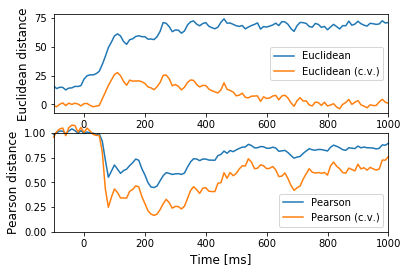

In [10]:
plt.subplot(211)
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result['ec'], axis=(0, 1, 2)), label='Euclidean')
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result_cv['ec_cv'], axis=(0, 1, 2)), label='Euclidean (c.v.)')
plt.xlim((-100, 1000))
plt.ylabel('Euclidean distance', fontsize=12)
plt.legend(loc='center right')

plt.subplot(212)
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result['ps'], axis=(0, 1, 2)), label='Pearson', clip_on=False)
plt.plot(np.arange(-100, 1001, 10), np.nanmean(result_cv['ps_cv'], axis=(0, 1, 2)), label='Pearson (c.v.)', clip_on=False)
plt.xlim((-100, 1000))
plt.ylim((0, 1))
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Pearson distance', fontsize=12)
plt.legend(loc='lower right')

**Euclidean distance:** with cross-validation, the Euclidean differences now approaches zero towards the end of an epoch. Thus, cross-validation removes the noise bias, which previously led to high Euclidean distances at the end of a trial despite the absence of true activation pattern differences (as indicated by decoding analyses).

**Pearson distance:** with cross-validation, correlation coefficients increase and thus the Pearson distance (1−r) shows a stronger negative deflection from 1. This result is expected, as 1) cross-validation corrects for effects of noise and 2) noise generally decreases correlation coefficients.